<a href="https://colab.research.google.com/github/alex-smith-uwec/CS-420/blob/main/Beam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple introduction to beam search

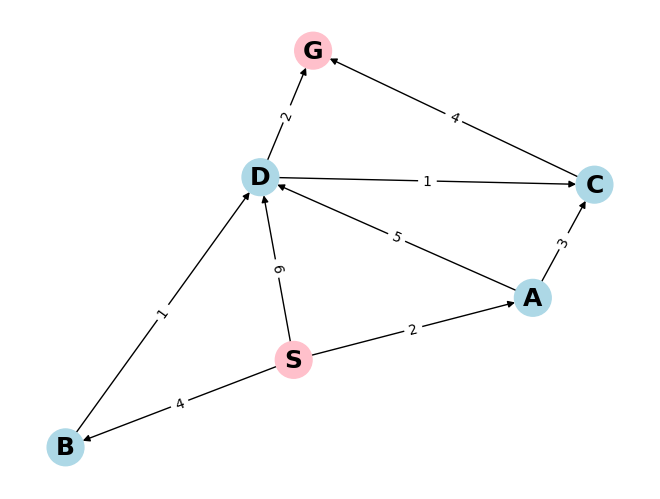

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the graph
graph = {
    'S': {'A': 2, 'B': 4, 'D': 6},
    'A': {'C': 3, 'D': 5},
    'B': {'D': 1},
    'C': {'G': 4},
    'D': {'G': 2, 'C':1},
    'G': {}
}

# Create a directed graph object
G = nx.DiGraph()

# Add edges to the graph
for node, neighbors in graph.items():
    for neighbor, weight in neighbors.items():
        G.add_edge(node, neighbor, weight=weight)

# Positioning of nodes
pos = nx.spring_layout(G,seed=42)

# Determine node colors
node_colors = []
for node in G.nodes():
    if node == 'S':
        node_colors.append('pink')
    elif node == 'G':
        node_colors.append('pink')
    else:
        node_colors.append('lightblue')

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color=node_colors, font_weight='bold', node_size=700, font_size=18)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Show the plot
plt.show()


Talk through beam search with this graph. S is "start" and G is "goal. Will use k=2 beams.

Start with greedy search (k=1).

One model is where edge weights are distances, so we want to minimize.
Another model is where edge weight are returns, like ounces of gold, so we want to maximize.


# Beam Search for sentence completion

Next let's work on a **huge** graph. The nodes are fragments that begin sentences in English, like "*All students are*" or  "*How to I train my dog*"

Two nodes will be connected if one is obtained for the other by concatenation of a single word or similar object like a question mark or period. For example, "*All students are*" and "*All students are expected*" are connected by an edge because we get the second fragment by concatenating the first with the word "expected".

The important question is **What are the weights of the edges?**
Here is the answer: the weight of an edge from fragment f1 to fragment f2=concatenate(f1,w) is the probability that word w follows f1 in natural language.

Of course this reduced the problem to a hard problem! How do we calculate these probabilities? We will simply use a large language model. For this demonstration we will use GPT-2. Here is what ChatGPT-4 says about GPT-2:





> GPT-2, which stands for "Generative Pre-trained Transformer 2," is a large-scale language model developed by OpenAI. It was released in February 2019 as an upgrade to the original GPT model. GPT-2 is based on the Transformer architecture and consists of 1.5 billion parameters, which make it significantly more powerful than its predecessor.

> The model is trained to predict the next word in a sequence of words, effectively enabling it to generate human-like text based on the text it is given as input. While not as advanced as later models like GPT-3 or GPT-4, GPT-2 was notable for its ability to perform a wide variety of language tasks without task-specific training data, including but not limited to text generation, summarization, translation, and question-answering. It can generate coherent and contextually relevant text over long passages, although it may produce text that is nonsensical or factually incorrect.


We will harness GPT-2 from the Transforms Library from Hugging Face.


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.7 MB/s eta 0:00:00


In [ ]:
import torch
from torch.nn.functional import softmax

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Initialize the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")




In [ ]:
def get_top_k_words(input_text, k=2):
    # Tokenize the input text and convert to tensor
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    #pt is for PyTorch. Would use tf if we were going to use TensorFlow

    # Get the model's prediction (logits)
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits

    # Get the logits for the last token in the input
    next_token_logits = logits[0, -1, :]

    # Softmax to transform the logits into probabilities
    probs = softmax(next_token_logits, dim=0)

    # Get the top k next tokens
    top_k = torch.topk(next_token_logits, k, dim=0)
    top_k_indices = top_k.indices

    # Create a list to store the top k words and their probabilities
    top_k_words_probs = []

    # Populate the list
    for i in range(k):
        next_token = top_k_indices[i].item()
        next_token_prob = probs[next_token].item()
        decoded_token = tokenizer.decode([next_token])
        top_k_words_probs.append((decoded_token, next_token_prob))

    # Sort the list in descending order by probability
    top_k_words_probs.sort(key=lambda x: x[1], reverse=True)

    return top_k_words_probs

#


In [ ]:
##Initial input text followed by sorted list of next most probable words.

input_text_0 = "Some math professors"
top_k_words_probs_0 = get_top_k_words(input_text_0,k=4)

# Print the sorted words and probabilities
for i, (word, prob) in enumerate(top_k_words_probs_0):
    print(f"{i+1}. {word} (Probability: {prob:.4f})")

1.  have (Probability: 0.0898)
2. , (Probability: 0.0829)
3.  are (Probability: 0.0793)
4.  and (Probability: 0.0673)


Image taken from [constrained-beam-search](https://huggingface.co/blog/constrained-beam-search)

This is the idea for how we will use beam search to expand our input_text. We will use GPT-2 to find the probabilties of the "next words" and sort them. In the image below we have k=3 beams.

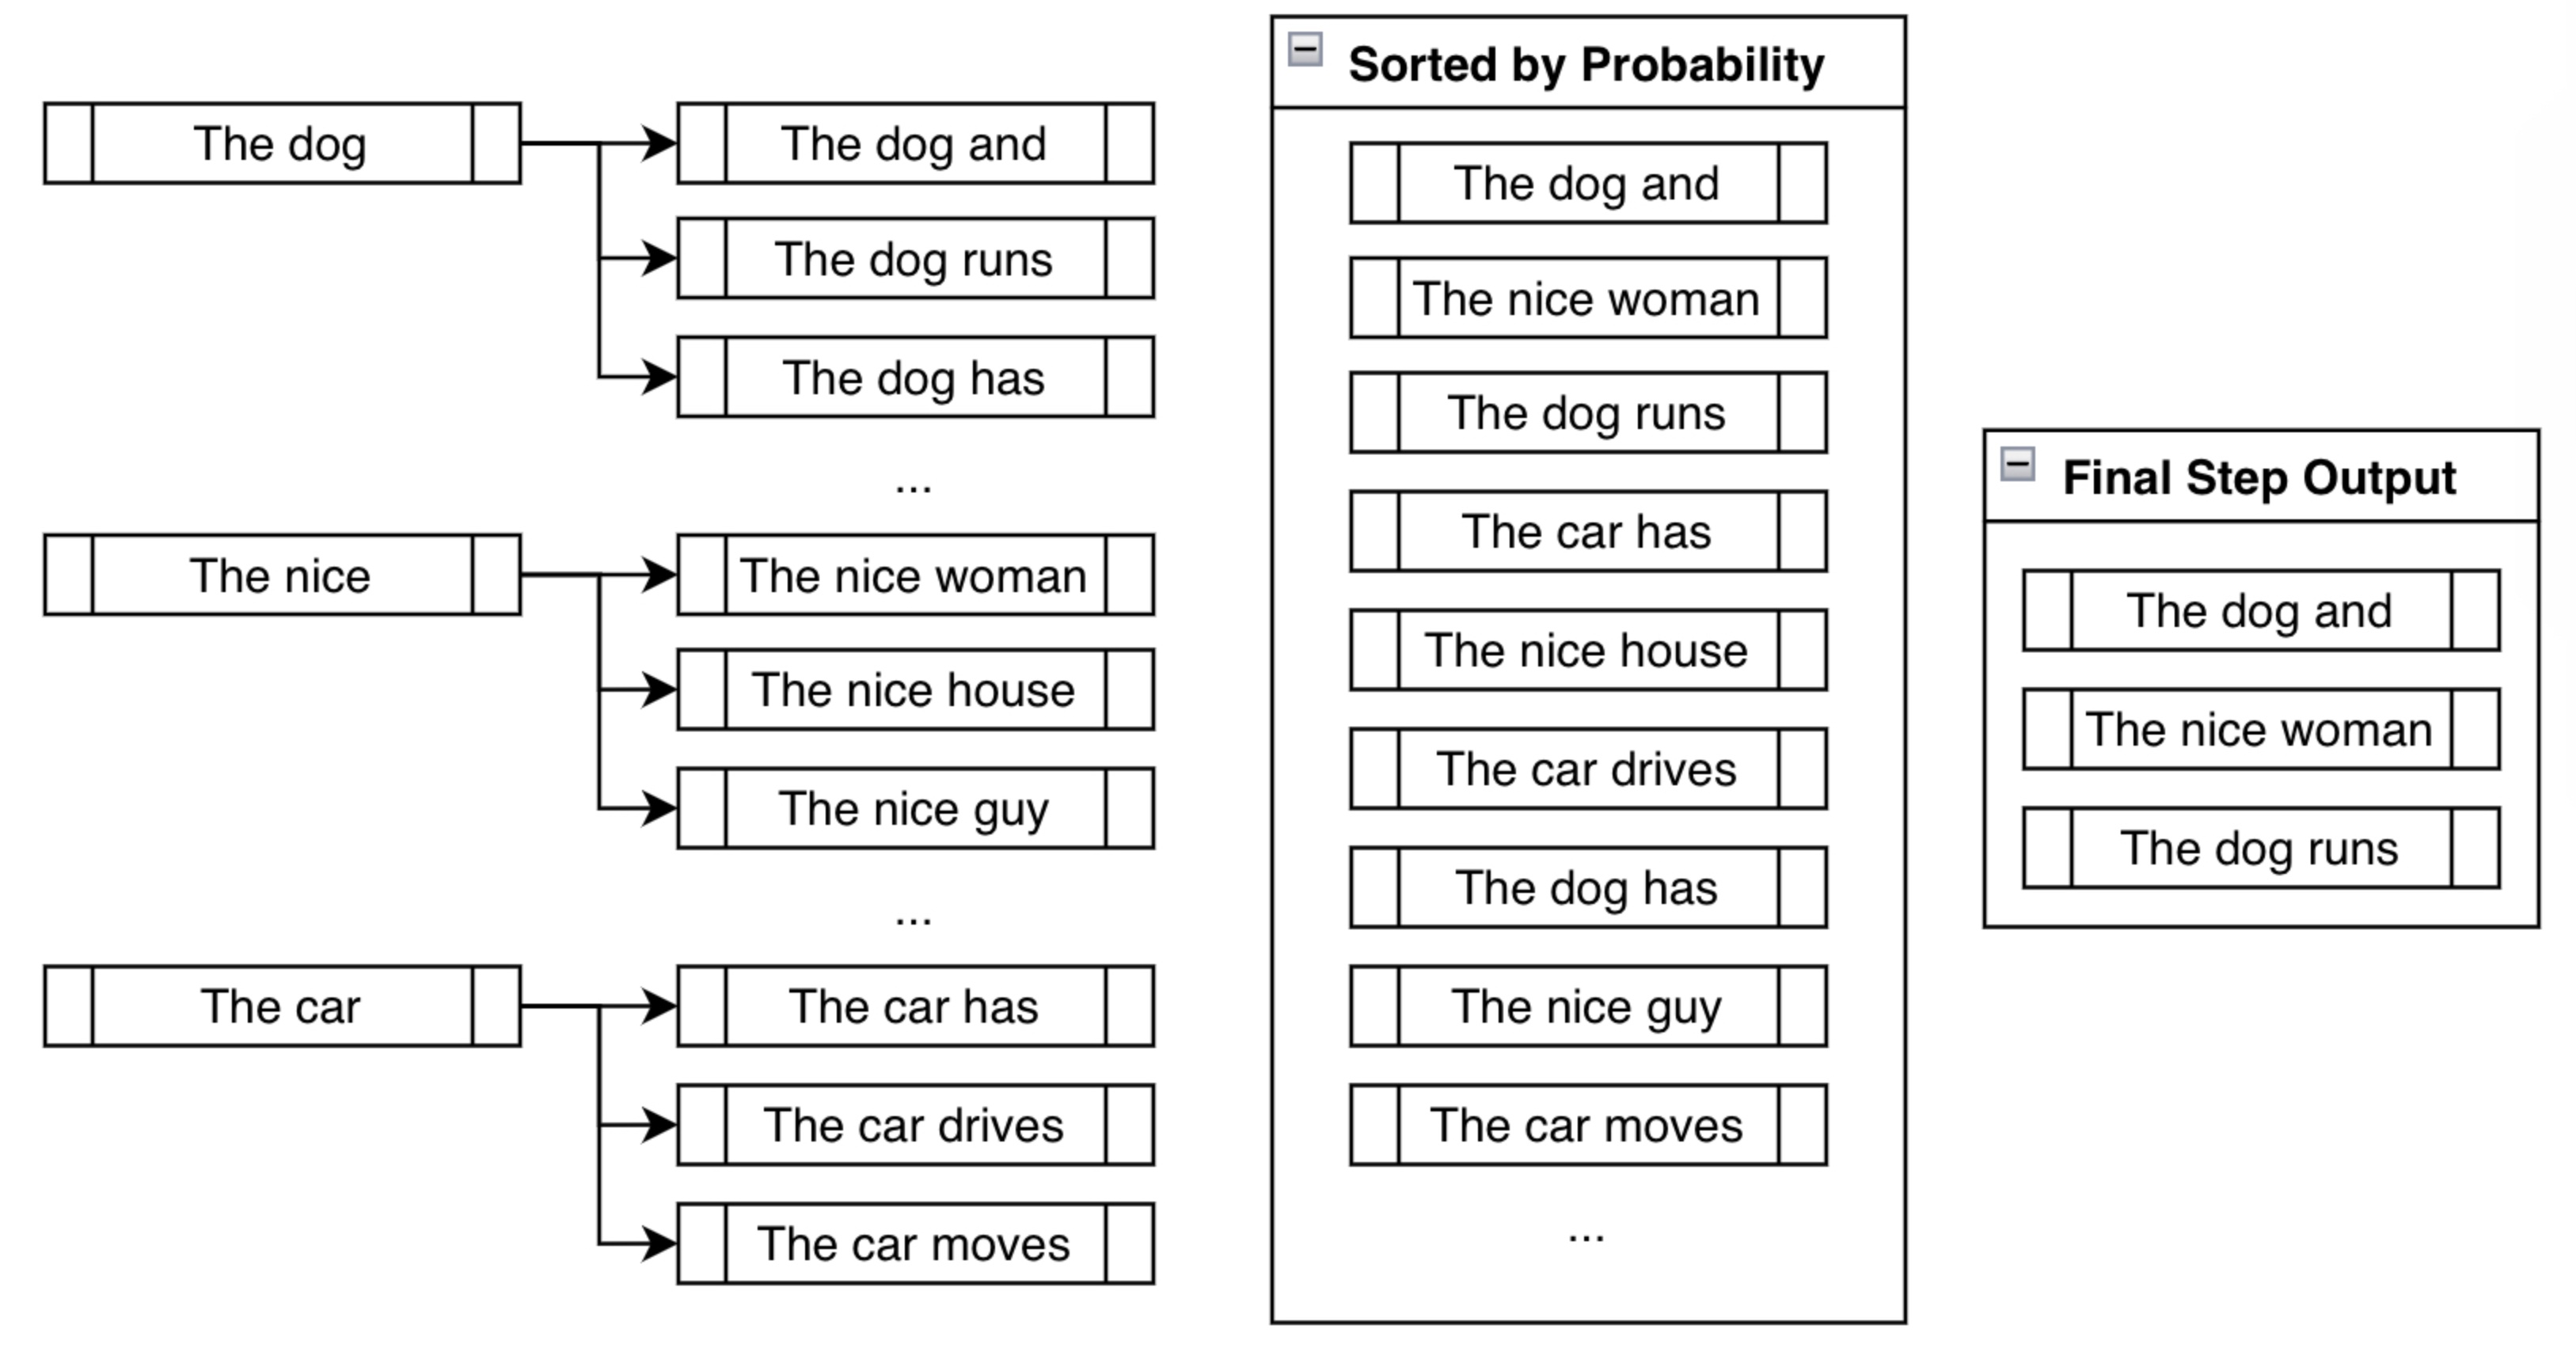

In [ ]:
input_text_1 = "Some math professors have"
input_text_2 = "Some math professors,"

In [ ]:
top_k_words_probs_1 = get_top_k_words(input_text_1, k=3)

# Print the sorted words and probabilities


top_k_words_probs_2 = get_top_k_words(input_text_2, k=3)

# Print the sorted words and probabilities
for i, (word, prob) in enumerate(top_k_words_probs_1):
    print(f"{i+1}. {word} (probability: {prob:.4f})")
print()#blank line for readability
for i, (word, prob) in enumerate(top_k_words_probs_2):
    print(f"{i+1}. {word} (probability: {prob:.4f})")

1.  been (probability: 0.0939)
2.  a (probability: 0.0307)
3.  said (probability: 0.0268)

1.  I (probability: 0.0547)
2.  however (probability: 0.0481)
3.  including (probability: 0.0406)


We are taking just 2 beams, but the code blocks are showing the top 3 most probable next words just for illustration. You can change k to 2 or higher.



*   Pick the two highest probabilities among the six that show.
*   Augment **input_text_1** and **input_text_2**
* Repeat until you get bored.






# How do we evaluate the "length" of a string of words generated by our above method?

In our simple minded example at the beginning with the graph with nodes S, A, B, C, D, G we evaluated the value of a path by adding. In one scenario, we wanted to minimize the value (distance). In the other scenario we wanted to maximize the value (ounces of gold picked up along the way).

For our text strings, it turns out that instead of adding the weights of the edges, which are probabilities, we **multiply** the probabilities. At first this might seem strange. But you can see why adding probabilities is feeble, since the sums could add up to be greater than 1!

The reason why mutiplication of the probabilities makes sense is rooted in the probability rule for conditional probability:

 $P(F \hbox{ and } W)=P(W\vert F)P(F)$

 We read this as "the probability of F and W is the probability of W *given* F times the probability of F

There is a conversion from the world where probabilties are multiplied to the world of information theory as developed by Claude Shannon, where information adds!

We use base-two logarithms in information theory. Base-two logs are called "bits."

Notice that $\log_2(1/2)=1$. So the information content of an event E with probability $1/2$ is one bit.

We have this important rule: $\log(p_1p_2)=\log(p_1)+\log(p_2)$. This comes from the basic rule of logarithms you learned in precalculus. So the log of a product is a sum of logarithms.

Instead of maximizing the product of probabilties, you can instead optimize the sum of the bits.

This has connections to machine learning (softmax) and statistical mechanics (partition function).




# Beam search in machine translation

Now let's have some fun with beam search as used in machine translation. Since some students in the class know Chinese I am translating from Chinese to English. The idea of how beam search is used is like above, but the weights between nodes are given by conditional probabilities

$P(\hbox{(first translated word}=w)\vert \hbox{foreign sentence})$ and so on with our k beams.


In [ ]:
!pip install sentencepiece

The MarianMTModel is a machine translation model based on the Transformer architecture, specifically tailored for translation tasks. It is part of the Hugging Face Transformers library and is designed to perform translation between multiple languages. The name "Marian" comes from Marian NMT, which stands for Multilingual Asynchronous Recurrent Neural network, although the current MarianMT models are based on the Transformer architecture and not RNNs.

In [ ]:
from transformers import MarianMTModel, MarianTokenizer

In [ ]:
# Initialize the MarianMT model and tokenizer for Chinese to English translation
model_name = 'Helsinki-NLP/opus-mt-zh-en'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In the code below we are using beam search in a high level way! Notice the argument **num_beams**.

If you are curious you can get some of the big ideas from this video [this video by Andrew Ng](https://youtu.be/RLWuzLLSIgw?si=phMUeG445AiYk7eY)

**Warning** the video is technical!

**If you get some error messages below then you need to fiddle around with restarting the runtime.**

In [ ]:
# Define your input sentence in Simplified Chinese
#input_sentence = "我爱数学。"
input_sentence="所有学生都需要一个计算器。"


# Encode the input sentence and generate translation outputs
input_ids = tokenizer(input_sentence, return_tensors="pt").input_ids
outputs = model.generate(input_ids, num_return_sequences=10, num_beams=10, early_stopping=True)

# Decode and print the output translations
for i, output in enumerate(outputs):
    decoded_output = tokenizer.decode(output, skip_special_tokens=True)
    print(f"Translation {i + 1}: {decoded_output}")

Translation 1: All students need a calculator.
Translation 2: All students needed a calculator.
Translation 3: All students require a calculator.
Translation 4: All students need an calculator.
Translation 5: All the students need a calculator.
Translation 6: All pupils need a calculator.
Translation 7: Every student needs a calculator.
Translation 8: All students will need a calculator.
Translation 9: And all students need a calculator.
Translation 10: All students need a calculator..
